# Spam Detection Machine Learning Classification

## Problem Statement
Email inboxes are inundated with unsolicited and low-value messages, making manual spam filtering inefficient and error-prone. This project applies supervised machine learning to automate the classification of email messages as spam or non-spam (ham). Because spam datasets are typically imbalanced, model evaluation emphasizes precision, recall, and F1-score rather than accuracy alone.


## 1. Data Loading and Preparaton

In [33]:
import pandas as pd

df = pd.read_csv('spam.csv', encoding='latin-1')
# Copy the dataset for reference
df_raw = df.copy()

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Empty columns are removed from the dataset. Only the text and labels columns are retained for modeling.

In [12]:
# Rename the columns as 'label' and 'message'
if 'v1' in df.columns and 'v2' in df.columns:
  df = df[['v1', 'v2']]
  df.columns =['label', 'message']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


There are no null values in the label or message columns.

##2.  Explore Data Analysis

In [13]:
display((df['label'].value_counts()))
df['label'].value_counts(normalize=True)

,count
label,
ham,4825
spam,747


,proportion
label,
ham,0.865937
spam,0.134063


To better understand differences between spam and non-spam messages, message length is compared across classes.  
The dataset is imbalanced (approximately 87% ham, 13% spam), so precision, recall, and F1-score are emphasized during evaluation.


In [14]:
df['word_count'] = df['message'].apply(lambda x: len(x.split()))
df['word_count'].describe()


,word_count
count,5572.000000
mean,15.494436
std,11.329427
min,1.000000
25%,7.000000
50%,12.000000
75%,23.000000
max,171.000000


Text(0, 0.5, 'Word Count')

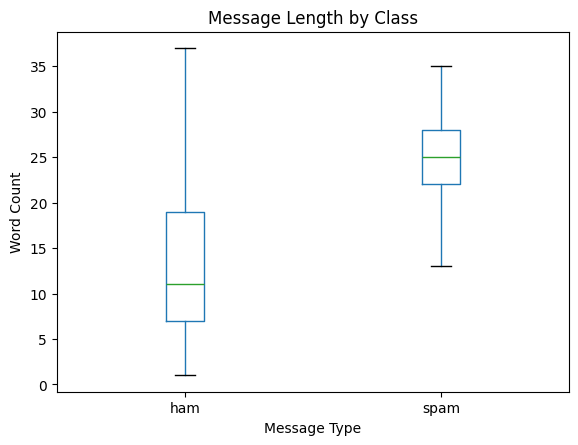

In [15]:
import matplotlib.pyplot as plt

df.boxplot(column='word_count', by='label', grid = False, showfliers=False)
plt.title('Message Length by Class')
plt.suptitle('')
plt.xlabel('Message Type')
plt.ylabel('Word Count')

Spam messages tend to have longer average lengths than non-spam messages, while non-spam messages show greater variability.


## 3. Text Preprocessing and Feature Engineering
### Structure Cleaning/Label Cleaning

Spam messages are encoded as class 1 and non-spam (ham) messages as class 0 to support binary classification.


In [16]:
# Converting labels to numberic. Spam will be class 1 and ham as class 0

df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

### Message Cleaning/Normalization





In [17]:
import re

def clean_text(text):
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove non-alphabetic characters
  text = re.sub(r'\s+',' ', text).strip() # normalize whitespace
  text = text.lower() # convert to lowercase
  return text

# Apply the clean_text function to the message column
df['clean_message'] = df['message'].apply(clean_text)

### CORPUS Building

In [18]:
corpus = df['clean_message'].tolist()

The corpus contains the cleaned message text used for feature extraction.

### Vectorization

Text messages are converted into numerical features using TF-IDF vectorization, the weighted Bag-of-Words representation, with unigrams and bigrams. Including bigrams allows the model to capture phrase-level patterns such as “free entry” or “claim now” that single words alone may miss.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features = 3000)
X = vectorizer.fit_transform(corpus)

X.shape

(5572, 3000)

TF-IDF vectorization transforms the corpus into a sparse numerical feature matrix. The result contains up to 3,000 weighted unigram and bigram features.

##4.  Modeling and Evaluation

Target Variable Definition


In [20]:
y = df['label_num']

Train-Test-Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=42, stratify=y)
# Stratifcation preserves spam/ham imbalance ratio

### Baseline Model (Majority Class)

In [22]:
# Baseline model
import numpy as np
from sklearn.metrics import classification_report

# The baseline model predicts the majority class by assigning a value of 0 (ham)
# to every test instance using np.zeros_like(y_test)
y_pred = np.zeros_like(y_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Warnings appear because the baseline model predicts only the majority class (ham), resulting in undefined precision for spam.

### Logistic Regression (default parameters)

In [23]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



The confusion matrix chart provides a class-level view of model prediction errors.


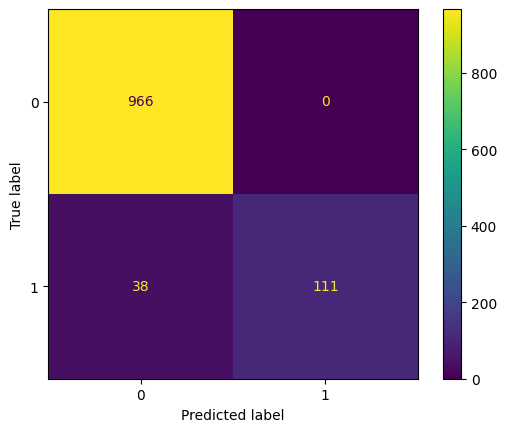

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)
plt.show()

**Model Interpretation:**

Logistic Regression provides a strong linear baseline with high overall accuracy and good spam recall, while remaining interpretable and well-calibrated.

*Precision* reflects how often messages predicted as spam are truly spam, *recall* measures how many actual spam messages are identified, and the *F1-score* balances these tow metrics to account for class imbalance.

### Random Forest (default parameters)


In [25]:
# This is the baseline ensemble model prior to parameter tuning.

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.82      0.89       149

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



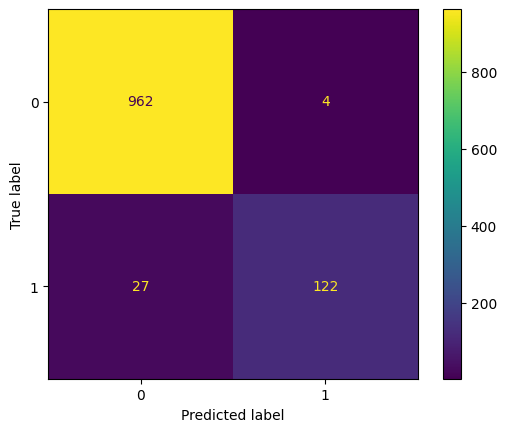

In [26]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()

**Model Interpretation:**

The Random Forest improves overall performance by aggregating multiple decision trees, achieving high precision and strong recall for spam detection.

| Model                | False Positives | False Negatives |
|----------------------|-----------------|-----------------|
| Logistic Regression  | 0               | 38              |
| Random Forest        | 4               | 27              |

Compared to Logistic Regression, the Random Forest model catches 11 additional spam messages but incorrectly flags 4 non-spam messages.

### ROC and AUC Charts for Spam and Ham Classification

ROC and AUC charts are used to evaluate the performance among the 2 models in separating spam from ham, showing the trade-offs between true positive and false positive rates at various threshold settings.

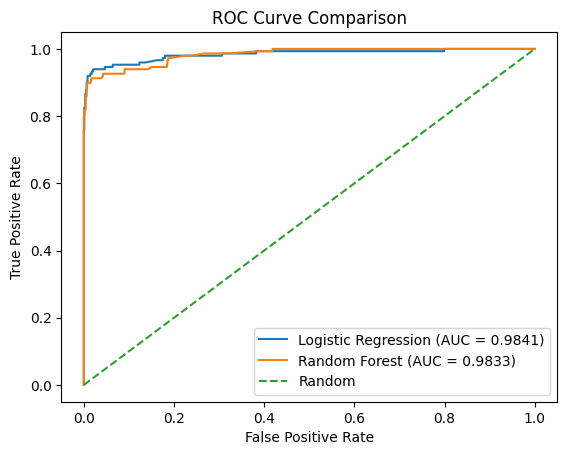

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

proba_lr = lr.predict_proba(X_test)[:,1]
proba_rf = rf.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)

auc_lr = roc_auc_score(y_test, proba_lr)
auc_rf = roc_auc_score(y_test, proba_rf)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.show()

**ROC-AUC Interpretation:**

While the Random Forest model achieves higher recall and F1-score at the default classification threshold (as reflected in the confusion matrices), both models perform very well overall, as shown by their high ROC–AUC values. This suggests that much of the distinction between spam and ham can be explained by a simple linear model.





##5. Exploratory Optional Extensions

### Bag of Words (Baseline - Exploratory)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=3000, stop_words='english')

X_bow = bow.fit_transform(corpus)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bow, y, test_size=.25,
                                                    random_state=42, stratify=y)
lr_bow = LogisticRegression()
# lr_bow = LogisticRegression(max_iter=1000)
lr_bow.fit(Xb_train, yb_train)

yb_pred = lr_bow.predict(Xb_test)
print(classification_report(yb_test, yb_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       1.00      0.84      0.91       187

    accuracy                           0.98      1393
   macro avg       0.99      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



As an exploratory comparison, a Bag-of-Words (raw word counts) representation is evaluated using Logistic Regression. Although Bag-of-Words achieves slightly higher spam recall on this dataset, its reliance on raw term frequency makes it more sensitive to dataset-specific words. TF-IDF is selected as the preferred representation because it provides greater robustness to various language patterns and better generalization on the dataset.

## Transformer-Based Model (BERT / Hugging Face – Exploratory)

In [29]:
from transformers import pipeline

bert_classifier = pipeline(
    'text-classification',
    model = 'distilbert-base-uncased-finetuned-sst-2-english',
    tokenizer = 'distilbert-base-uncased-finetuned-sst-2-english'
)

sample_text = df['message'].sample(10, random_state=42).tolist()
bert_predictions = bert_classifier(sample_text)
list(zip(sample_text, bert_predictions)
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[('Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens',
  {'label': 'NEGATIVE', 'score': 0.9798550009727478}),
 ('I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones',
  {'label': 'NEGATIVE', 'score': 0.9967228770256042}),
 ('We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p',
  {'label': 'POSITIVE', 'score': 0.7033657431602478}),
 ("Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.",
  {'label': 'POSITIVE', 'score': 0.998941957950592}),
 ('Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16',
  {'

**Transformer-Based Model (Exploratory):**

A pretrained DistilBERT model from Hugging Face is explored using the transformers pipeline to explore transformer-based NLP models. The model is fine-tuned for sentiment analysis rather than spam classification, so results are not directly comparable to supervised models trained on the dataset. Due to this mismatch and higher computational cost, classical TF-IDF–based models remain the preferred solution for this task.

##6. Final Summary
This project evaluates multiple supervised learning approaches for spam classification using TF-IDF text features under class imbalance. A majority-class baseline demonstrates that accuracy alone is insufficient, motivating the use of precision, recall, F1-score, and ROC–AUC for evaluation.

Logistic Regression and Random Forest models both achieve strong performance. Logistic Regression provides a stable and interpretable linear baseline with well-calibrated probabilities, while the default Random Forest model achieves higher precision and competitive recall by aggregating multiple decision trees. Excessive regularization of the Random Forest leads to underfitting and reduced spam recall, illustrating the importance of balancing model complexity with dataset characteristics.


##7. Recommendation
Alternative feature representations, including bigrams and Bag-of-Words, produce results comparable to unigram TF-IDF, indicating stable model behavior and the keyword-driven nature of SMS spam. A pretrained BERT-based model from Hugging Face is explored to gain exposure to modern NLP techniques, but does not provide a clear advantage for this short-text classification task due to higher computational cost and the lack of task-specific fine-tuning.

For spam filtering applications where false positives are more costly than false negatives, the default Random Forest model is preferred due to its high precision and robust performance. Logistic Regression remains a strong alternative when interpretability and simplicity are prioritized.